<a href="https://colab.research.google.com/github/Ecevangelista/422_Classification_Bankruptcy/blob/main/Assignment_4_Bankruptcy_1_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import numpy as np
from numpy import arange
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm,uniform, reciprocal
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, PrecisionRecallDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
import plotly.express as px

# Ingest

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "drive/MyDrive/422NU/bankruptcy_data.csv"
df = pd.read_csv(path)

In [4]:
df.shape

(6819, 96)

# EDA

In [26]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [ ]:
df.tail()

In [ ]:
pd.set_option('display.max_columns', 96)
df.describe()

Several features labeled as ratios have Max values in the billions, which is not logical for a ratio. These are candidates to explore for outliers: 
Interest-bearing interest rate, Current Ratio, Quick Ratio, Quick Assets/Current Liability, Cash/Current Liability, Long-term Liability to Current Assets 

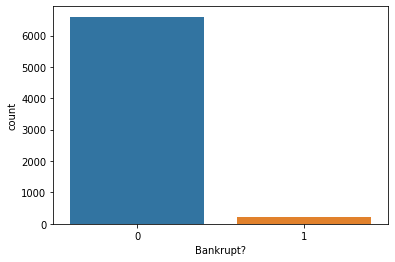

In [6]:
#Countplot of Bankrupt?

sns.countplot(x =df['Bankrupt?'], data = df)
 
plt.show()

In [11]:
bank = df[df['Bankrupt?'] ==1]
bank.shape

(220, 96)

Countplot of Bankrupt shows very low instances of Bankrupcty (1 values)

In [7]:
#Correlation with Bankrupt
pd.set_option('display.max_rows', None)

corr = df.corr()['Bankrupt?']
corr[np.argsort(corr,axis=0)[::-1]]

Bankrupt?                                                   1.000000
 Equity to Liability                                       -0.083048
 Debt ratio %                                               0.250161
 Current Liability to Assets                                0.194494
 Borrowing dependency                                       0.176543
 Current Liability to Current Assets                        0.171306
 Liability to Equity                                        0.166812
 Current Liabilities/Equity                                 0.153828
 Current Liability to Equity                                0.153828
 Liability-Assets Flag                                      0.139212
 Total expense/Assets                                       0.139049
 Equity to Long-term Liability                              0.139014
 Cash/Current Liability                                     0.077921
 Inventory and accounts receivable/Net value                0.075278
 Fixed Assets Turnover Frequency  

Variables with negative correlation indicate variables correlated with 0 Bankruptcy and variables with positive correlation indicate strong relationship to Bankruptcy. 

Exploring features related to Profitability and Solvency for consideration in the model and checking those features with Max values in the billions.

In [ ]:
#Looking at the shape of Interest-bearing debt interest rate to assess whether there's a relationship between the mean bankrupt rate across different interest values   
histfunc = "avg"
fig = px.histogram(df, 
                   x=" Interest-bearing debt interest rate", 
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
#fig.update_layout(yaxis_title="Number of Countries")
fig.show()

In [6]:
#Look at histogram with Interest-bearing debt interest rate for values <1
#Rows with Interest-bearing debt interest rate <1 appear to have lower probabilities to be bankrupt

intbear0 = df[df[' Interest-bearing debt interest rate'] <= 1]

histfunc = "avg"
fig = px.histogram(intbear0,
                   x=' Interest-bearing debt interest rate',
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
fig.show()

In [ ]:
#Separating rows with Interest-bearing debt interest rate >1
#Majority of the rows have Bankrupt? value of 0, only 1 instance of Bankrupt? =1. Ok to remove these values from dataset as it shouldn't affect the distribution of the Bankrupt? values too much.


intbear100 = df[df[' Interest-bearing debt interest rate'] >= 1]
intbear100

In [ ]:
#Looking at Current Ratio outliers
#Only 1 value of Current Ratio >1 and the value of Current Ratio is in the billions, so removing from dataset should be ok

currentrat1 = df[df[' Current Ratio'] >1]
currentrat1


In [7]:
#Look at histogram with Interest-bearing debt interest rate for values <1
#Histogram indicates a relationship with mean Bankruptcy probability. Current Ratio values >0.1 have higher likelihood of Bankruptcy


currentrat0 = df[df[' Current Ratio'] <=1]

histfunc = "avg"
fig = px.histogram(currentrat0,
                   x=' Current Ratio',
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
fig.show()

In [ ]:
#Look at Quick Ratio. Based on the definition of Quick Ratio, a ratio of 1 is typical, so values in the billions indicate possible entry errors.
#Majority of the rows have Bankrupt? value of 0, only 1 instance of Bankrupt? =1. Ok to remove these values from dataset as it shouldn't affect the distribution of the Bankrupt? values too much.

quickratioout = df[df[' Quick Ratio'] >= 1]
quickratioout


In [ ]:
#Histogram of rows with Quick Ratio <1 indicates relationship between Quick Ratio and average Bankrupt? probabilities

quickratio0 = df[df[' Quick Ratio'] < 1]

histfunc = "avg"
fig = px.histogram(quickratio0,
                   x=' Quick Ratio',
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
fig.show()

In [9]:
#Look at outliers with Quick Assets/Current Liability
#No rows with Quick Assets/Current Liability >1 have Bankrupt = 1, so ok to remove from dataset

quickassets1 = df[df[' Quick Assets/Current Liability'] >= 1]
quickassets1

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
2063,0,0.494418,0.562200,0.544408,0.607316,0.607316,0.999085,0.797568,0.809457,0.303594,0.781726,0.000104,0.0,0.463250,8.940894e-04,0.149712,0.187771,0.187771,0.187771,0.230027,0.323442,0.021674,0.107727,0.186111,0.022076,0.848016,0.689385,0.689385,0.217592,6.260000e+09,5.086951e-04,0.263939,0.385679,0.011178,0.000197,0.632894,8.266535e-03,0.140551,0.859449,0.006673,...,0.878882,0.015447,8.140000e+09,0.000556,0.147365,0.346231,0.278049,0.028993,0.996929,0.740619,0.333579,0.0,0.938696,0.002590,0.008849,4.753158e-04,1.290000e+08,0.594068,2.220000e+09,0.671578,0.076382,0.996929,0.333579,0.110933,0.648366,0.460259,0.590007,0.315531,0.026161,0,0.814600,0.004078,0.622255,0.607316,0.841685,0.280774,0.026793,0.565165,1,0.026120
2168,0,0.488714,0.561328,0.543552,0.620894,0.620894,0.999303,0.797705,0.809612,0.303376,0.781893,0.000103,0.0,0.458843,6.630663e-04,0.000000,0.186676,0.186676,0.186676,0.232296,0.301408,0.012206,0.114649,0.184153,0.022086,0.848050,0.689427,0.689427,0.217596,8.050000e+09,4.607577e-04,0.264005,0.347416,0.007486,0.000101,0.632479,1.877183e-02,0.199534,0.800466,0.007723,...,0.840226,0.006634,8.820000e+09,0.000169,0.207915,0.333025,0.279411,0.019450,0.998851,0.737717,0.342885,496000000.0,0.940368,0.002634,0.005731,1.293356e-03,3.470000e+09,0.594093,2.660000e+08,0.671578,0.031100,0.998851,0.342885,0.110945,0.644913,0.459530,0.515708,0.315129,0.038701,0,0.809511,0.009606,0.617664,0.620894,0.841954,0.288393,0.027092,0.566275,1,0.017292
2490,0,0.412178,0.474270,0.457733,0.000000,0.000000,0.988045,0.784312,0.796607,0.303526,0.767874,0.001407,0.0,0.000000,3.450345e-04,0.000000,0.199444,0.199444,0.199444,0.198733,0.314600,0.000257,0.082078,0.156737,0.021601,0.847191,0.683591,0.683591,0.216859,8.580000e+09,5.201741e-04,0.262968,0.372238,1.000000,1.000000,0.630605,4.7

In [ ]:
# Look at rows with Cash/Current Liability
# 15 rows have Bankrupt = 1

cash_liab1 = df[df[' Cash/Current Liability'] >=1]
cash_liab1

In [ ]:
#Look at rows with Long-term Liability to Current Assets>1
#Majority of the rows have Bankrupt? value of 0, only 2 instances of Bankrupt? =1. Ok to remove these values from dataset as it shouldn't affect the distribution of the Bankrupt? values too much.

long_liab1 = df[df[' Long-term Liability to Current Assets'] >=1]
long_liab1

Exploring features related to Profitability and Solvency with high correlation to Bankruptcy

In [12]:
#Persistent EPS in the Last Four Seasons Histogram indicates that EPS <0.17 yields higher probability of bankruptcy

histfunc = "avg"
fig = px.histogram(df,
                   x=' Persistent EPS in the Last Four Seasons',
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
fig.show()

In [ ]:
#Histogram of Current Liability to Assets shows that rows with Current Liability to Assets >0.3 tend to have higher probability of bankruptcy

histfunc = "avg"
fig = px.histogram(df,
                   x=' Current Liability to Assets',
                   y="Bankrupt?",
                   histfunc=histfunc,
                   title=f"histfunc = {histfunc}")
fig.show()

In [13]:
#Limiting dataset to Features related to Profitability and Solvency

df1 = df.copy(deep = True)


In [14]:
#Limiting dataset to Features related to Profitability and Solvency

df1 = df1[['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Realized Sales Gross Margin', ' Gross Profit to Sales',
           ' Operating Profit Rate', ' Persistent EPS in the Last Four Seasons', ' Interest-bearing debt interest rate', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Interest Expense Ratio', ' Current Liability to Assets',
           ' Operating Funds to Liability', ' Inventory/Working Capital', ' Current Liabilities/Liability', ' Working Capital/Equity', ' Current Liabilities/Equity',  ' Long-term Liability to Current Assets',
           ' Quick Assets/Total Assets', ' Current Assets/Total Assets', ' Cash/Total Assets', ' Quick Assets/Current Liability', ' Cash/Current Liability', ' Equity to Liability' ]]

df1.shape

(6819, 26)

In [15]:
#Dropping rows with Outliers

df1.drop(df1[df1[' Quick Ratio'] >= 1].index, inplace = True)
df1.shape

(6809, 26)

In [16]:
df1.drop(df1[df1[' Long-term Liability to Current Assets'] >= 1].index, inplace = True)
df1.shape

(6699, 26)

In [17]:
df1.drop(df1[df1[' Interest-bearing debt interest rate'] >= 1].index, inplace = True)
df1.shape

(6480, 26)

In [19]:
df1.drop(df1[df1[' Cash/Current Liability'] >= 1].index, inplace = True)
df1.shape

(6439, 26)

In [20]:
df1.drop(df1[df1[' Quick Assets/Current Liability'] >= 1].index, inplace = True)
df1.shape

(6438, 26)

In [21]:
df1.drop(df1[df1[' Current Ratio'] > 1].index, inplace = True)
df1.shape

(6437, 26)

In [22]:
df2 = df1.copy(deep = True)

# Dummy Classifier Model

I ran a dummy classifier model to look at the occurrence of Bankrupt vs. Not Bankrupt within the edited dataset.

In [23]:
#split df into test and train
Xd = df2.drop(columns = ['Bankrupt?'])
yd = df2['Bankrupt?']


X_traind, X_testd, y_traind, y_testd = train_test_split(Xd,yd, test_size = 0.2, random_state = 10)

In [24]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_traind,y_traind)
pred_dum= dummy_classifier.predict(X_testd)
accuracy_score(y_testd, pred_dum)

0.9627329192546584

# Naive Bayes Classifier - Baseline

In [27]:
#split into test and train
Xnb = df2.drop(columns = ['Bankrupt?'])
ynb = df2['Bankrupt?']


X_trainnb, X_testnb, y_trainnb, y_testnb = train_test_split(Xnb,ynb, test_size = 0.2, random_state = 10)

In [28]:
gnb = GaussianNB()

gnb_mod = gnb.fit(X_trainnb, y_trainnb)

In [29]:
gnb_pred = gnb_mod.predict(X_testnb)

Goodness of Fit and Performance metrics on Test set: Naive Bayes

In [30]:
acc_score = accuracy_score(y_testnb, gnb_pred)
acc_score

0.8183229813664596

In [31]:
#naive bayes confusion matrix

cm_nb = confusion_matrix(y_testnb, gnb_pred)

print('Confusion Matrix\n\n', cm_nb)

print('\nTrue Negatives Not-Bankrupt(TN) = ', cm_nb[0,0])

print('\nTrue Positive Bankrupt (TP) = ', cm_nb[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , cm_nb[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , cm_nb[1,0])

Confusion Matrix

 [[1015  225]
 [   9   39]]

True Negatives Not-Bankrupt(TN) =  1015

True Positive Bankrupt (TP) =  39

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  225

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  9


In [40]:
#TRUE POSITIVE RATE AND RECALL NAIVE BAYES Test


recall_nb1 = recall_score(y_testnb, gnb_pred)
recall_nb1

0.8125

In [39]:
#Precision Naive Bayes Test
precision_nb1 = precision_score(y_testnb, gnb_pred)
precision_nb1

0.14772727272727273

In [42]:
#False Positive Rate Naive Bayes Test

fpr_nb = cm_nb[0,1]/(cm_nb[0,1] + cm_nb[0,0])
print("False Positive Rate:", fpr_nb)


False Positive Rate: 0.1814516129032258


In [36]:
#F1 SCORE NAIVE BAYES

f1_nb = f1_score(y_testnb, gnb_pred)
print("F1 NB", f1_nb)

F1 NB 0.25000000000000006


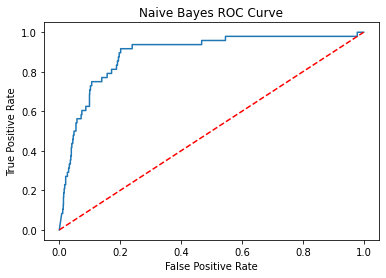

In [37]:
#ROC CURVE NAIVE BAYES

nb_pred_proba = gnb.predict_proba(X_testnb)[::,1]
fpr,tpr,_ = roc_curve(y_testnb, nb_pred_proba)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.show()

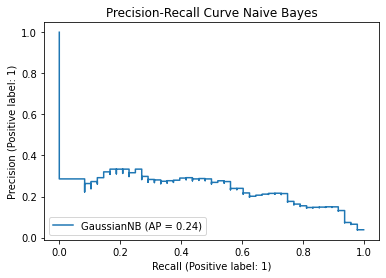

In [38]:
#Precision Recall Naive Bayes

PrecisionRecallDisplay.from_estimator(gnb, X_testnb, y_testnb)
plt.title("Precision-Recall Curve Naive Bayes")
plt.show()

Goodness of Fit and Performance metrics on Train set: Naive Bayes

In [43]:
#NB Predictions TRAIN

gnbpred_train = gnb_mod.predict(X_trainnb)

In [44]:
#Accuracy Naive Bayes TRAIN

nb_trainacc_score = accuracy_score(y_trainnb, gnbpred_train)
nb_trainacc_score

0.8252087784035735

In [45]:
#naive bayes confusion matrix train

cm_nbtrain = confusion_matrix(y_trainnb, gnbpred_train)

print('Confusion Matrix\n\n', cm_nbtrain)

print('\nTrue Negatives Not-Bankrupt(TN) = ', cm_nbtrain[0,0])

print('\nTrue Positive Bankrupt (TP) = ', cm_nbtrain[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , cm_nbtrain[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , cm_nbtrain[1,0])

Confusion Matrix

 [[4129  869]
 [  31  120]]

True Negatives Not-Bankrupt(TN) =  4129

True Positive Bankrupt (TP) =  120

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  869

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  31


In [46]:
#Precision TRAIN NB
precision_nbtrain = precision_score(y_trainnb, gnbpred_train)
precision_nbtrain

0.12133468149646107

In [47]:
#True Positive Rate and recall TRAIN NB
recall_nbtrain = recall_score(y_trainnb, gnbpred_train)
recall_nbtrain

0.7947019867549668

In [49]:
#False Positive Rate Train Naive Bayes

fpr_nbtrain = cm_nbtrain[0,1]/(cm_nbtrain[0,1] + cm_nbtrain[0,0])
print("False Positive Rate:", fpr_nbtrain)


False Positive Rate: 0.17386954781912764


# Logistic Regression

In [50]:
#split into test and train
Xlog = df2.drop(columns = ['Bankrupt?'])
ylog = df2['Bankrupt?']


X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(Xlog,ylog, test_size = 0.2, random_state = 10)

In [51]:
logreg = LogisticRegression()

mod_log = logreg.fit(X_trainlog, y_trainlog)

Goodness of Fit and Performance metrics on Test set: Logistic Regression

In [52]:
log_pred = logreg.predict(X_testlog)

In [53]:
#Logistic Confusion Matrix TEST

conmat_log = confusion_matrix(y_testlog, log_pred)

print('Confusion Matrix\n\n', conmat_log)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_log[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_log[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_log[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_log[1,0])

Confusion Matrix

 [[1239    1]
 [  47    1]]

True Negatives Not-Bankrupt(TN) =  1239

True Positive Bankrupt (TP) =  1

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  1

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  47


In [54]:
#Precision Logistic test
precision_log = precision_score(y_testlog, log_pred)
precision_log

0.5

In [55]:
#recall Logistic test
recall_log = recall_score(y_testlog, log_pred)
recall_log

0.020833333333333332

In [56]:
#Accuracy Logistic test
log_acc_score = accuracy_score(y_testlog, log_pred)
log_acc_score

0.9627329192546584

In [57]:
#False Positive Rate Logistic Regression Test

fpr_logtest = conmat_log[0,1]/(conmat_log[0,1] + conmat_log[0,0])
print("False Positive Rate:", fpr_logtest)


False Positive Rate: 0.0008064516129032258


In [58]:
#F1 SCORE Logistic test

f1_log = f1_score(y_testlog, log_pred)
print("F1 Logistic", f1_log)

F1 Logistic 0.039999999999999994


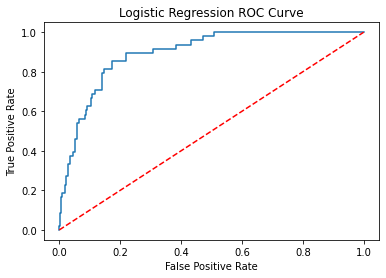

In [59]:
#ROC CURVE Logistic test

log_pred_proba = logreg.predict_proba(X_testlog)[::,1]
fpr,tpr,_ = roc_curve(y_testlog, log_pred_proba)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

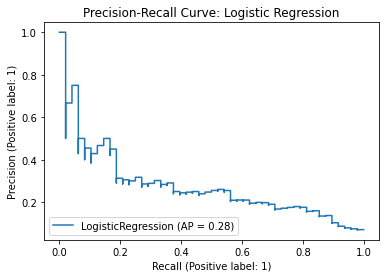

In [60]:
#Precision Recall Logistic test

PrecisionRecallDisplay.from_estimator(logreg, X_testlog, y_testlog)
plt.title("Precision-Recall Curve: Logistic Regression")
plt.show()

Goodness of Fit and Performance metrics on Train set: Logistic Regression

In [61]:
log_predtrain = logreg.predict(X_trainlog)

In [62]:
#Logistic Confusion Matrix TRAIN

conmat_logtrain = confusion_matrix(y_trainlog, log_predtrain)

print('Confusion Matrix\n\n', conmat_logtrain)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_logtrain[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_logtrain[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_logtrain[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_logtrain[1,0])

Confusion Matrix

 [[4993    5]
 [ 140   11]]

True Negatives Not-Bankrupt(TN) =  4993

True Positive Bankrupt (TP) =  11

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  5

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  140


In [63]:
#Precision Logistic TRAIN
precision_logtrain = precision_score(y_trainlog, log_predtrain)
precision_logtrain

0.6875

In [64]:
#recall Logistic train
recall_logtrain = recall_score(y_trainlog, log_predtrain)
recall_logtrain

0.0728476821192053

In [65]:
#Accuracy train
log_acc_scoretrain = accuracy_score(y_trainlog, log_predtrain)
log_acc_scoretrain

0.9718391920761313

In [66]:
#False Positive Rate Logistic Regression Train

fpr_logtrain = conmat_logtrain[0,1]/(conmat_logtrain[0,1] + conmat_logtrain[0,0])
print("False Positive Rate:", fpr_logtrain)

False Positive Rate: 0.0010004001600640256


# SVM: SVC with Linear kernel,default C and gamma

In [67]:
#split into test and train
Xsvc = df2.drop(columns = ['Bankrupt?'])
ysvc = df2['Bankrupt?']


X_trainsvc, X_testsvc, y_trainsvc, y_testsvc = train_test_split(Xsvc,ysvc, test_size = 0.2, random_state = 10)

In [68]:
msvc = SVC(kernel='linear')

mod_svc = msvc.fit(X_trainsvc, y_trainsvc)

Goodness of Fit and Performance metrics on Test set: SVC with Linear kernel and defaults

In [69]:
msvc_pred_test = msvc.predict(X_testsvc)

In [70]:
#Accuracy TEST
msvc_acc_scoretest = accuracy_score(y_testsvc, msvc_pred_test)
msvc_acc_scoretest

0.9627329192546584

In [71]:
#MSVC Confusion Matrix TEST

conmat_msvctest = confusion_matrix(y_testsvc, msvc_pred_test)

print('Confusion Matrix\n\n', conmat_msvctest)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_msvctest[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_msvctest[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_msvctest[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_msvctest[1,0])

Confusion Matrix

 [[1240    0]
 [  48    0]]

True Negatives Not-Bankrupt(TN) =  1240

True Positive Bankrupt (TP) =  0

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  0

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  48


In [72]:
#Precision MSVC TEST
precision_msvctest = precision_score(y_testsvc, msvc_pred_test)
precision_msvctest

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.0

In [73]:
#recall MSVC TEST
recall_msvctest = recall_score(y_testsvc, msvc_pred_test)
recall_msvctest

0.0

In [74]:
#False Positive Rate SVM Linear Kernel default Test

fpr_msvctest = conmat_msvctest[0,1]/(conmat_msvctest[0,1] + conmat_msvctest[0,0])
print("False Positive Rate:", fpr_msvctest)

False Positive Rate: 0.0


In [75]:
#F1 SCORE MSVC test

f1_msvc = f1_score(y_testsvc, msvc_pred_test)
print("F1 MSVC", f1_msvc)

F1 MSVC 0.0


In [76]:
#ROC CURVE MSVC test
#ROC Curve not possible when 0 Positive values were predicted

msvc_pred_proba = msvc.predict_proba(X_testsvc)[::,1]
fpr,tpr,_ = roc_curve(y_testsvc, msvc_pred_proba)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('SVC Linear Kernel ROC Curve')
plt.show()

AttributeError: ignored

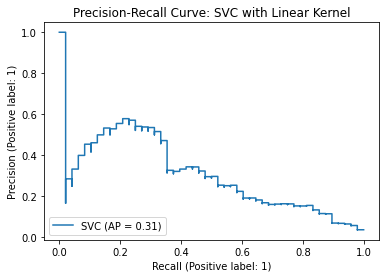

In [77]:
#Precision Recall MSVC test

PrecisionRecallDisplay.from_estimator(msvc, X_testsvc, y_testsvc)
plt.title("Precision-Recall Curve: SVC with Linear Kernel")
plt.show()

Goodness of Fit and Performance metrics on Train set: SVC with Linear kernel and defaults

In [78]:
msvc_pred_train = msvc.predict(X_trainsvc)

In [79]:
#Accuracy TRAIN MSVC
msvc_acc_scoretrain = accuracy_score(y_trainsvc, msvc_pred_train)
msvc_acc_scoretrain

0.9706739172654885

In [80]:
#MSVC Confusion Matrix TRAIN

conmat_msvctrain = confusion_matrix(y_trainsvc, msvc_pred_train)

print('Confusion Matrix\n\n', conmat_msvctrain)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_msvctrain[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_msvctrain[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_msvctrain[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_msvctrain[1,0])

Confusion Matrix

 [[4998    0]
 [ 151    0]]

True Negatives Not-Bankrupt(TN) =  4998

True Positive Bankrupt (TP) =  0

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  0

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  151


In [81]:
#Precision MSVC Train
precision_msvctrain = precision_score(y_trainsvc, msvc_pred_train)
precision_msvctrain

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.0

In [82]:
#recall MSVC Train
recall_msvctrain = recall_score(y_trainsvc, msvc_pred_train)
recall_msvctrain

0.0

In [83]:
#False Positive Rate SVM Linear Kernel default Train

fpr_msvctrain = conmat_msvctrain[0,1]/(conmat_msvctrain[0,1] + conmat_msvctrain[0,0])
print("False Positive Rate:", fpr_msvctrain)

False Positive Rate: 0.0


# SVM: SVC with Linear kernel and hyperparameter tuning with Randomized Search CV

In [84]:
#split into test and train
Xsvct = df2.drop(columns = ['Bankrupt?'])
ysvct = df2['Bankrupt?']


X_trainsvct, X_testsvct, y_trainsvct, y_testsvct = train_test_split(Xsvct,ysvct, test_size = 0.2, random_state = 10)

In [85]:
msvct = SVC(kernel='linear')

#mod_svct = msvct.fit(X_trainsvct, y_trainsvct)

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

clf = RandomizedSearchCV(msvct, param_distributions, random_state=0)
search = clf.fit(X_trainsvct, y_trainsvct)
search.best_params_

{'C': 6.4881350392732475, 'gamma': 0.026938830192854094}

In [86]:
#Trying SVC with best params

msvc2 = SVC(C = 6.4881350392732475, kernel = "linear", gamma = 0.026938830192854094)

mod_msvc2 = msvc2.fit(X_trainsvct, y_trainsvct)

Goodness of Fit and Performance metrics on Test set: SVC with Linear kernel, C: 6.488, Gamma: 0.269

In [87]:
msvc2_pred_test = msvc2.predict(X_testsvct)

In [88]:
#Accuracy Test MSVC2
msvc2_acc_scoretest = accuracy_score(y_testsvct, msvc2_pred_test)
msvc2_acc_scoretest

0.9627329192546584

In [89]:
#MSVC2 Confusion Matrix TEST

conmat_msvc2test = confusion_matrix(y_testsvct, msvc2_pred_test)

print('Confusion Matrix\n\n', conmat_msvc2test)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_msvc2test[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_msvc2test[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_msvc2test[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_msvc2test[1,0])

Confusion Matrix

 [[1240    0]
 [  48    0]]

True Negatives Not-Bankrupt(TN) =  1240

True Positive Bankrupt (TP) =  0

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  0

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  48


In [90]:
#Precision MSVC Test svc2
precision_msvctest2 = precision_score(y_testsvct, msvc2_pred_test)
precision_msvctest2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.0

In [91]:
#recall Test svc2
recall_msvctest2 = recall_score(y_testsvct, msvc2_pred_test)
recall_msvctest2

0.0

In [92]:
#False Positive Rate SVM Linear Kernel Tuned Test

fpr_msvc2test = conmat_msvc2test[0,1]/(conmat_msvc2test[0,1] + conmat_msvc2test[0,0])
print("False Positive Rate:", fpr_msvc2test)

False Positive Rate: 0.0


In [93]:
#F1 SCORE MSVC test

f1_msvc2 = f1_score(y_testsvct, msvc2_pred_test)
print("F1 MSVC2", f1_msvc2)

F1 MSVC2 0.0


In [94]:
#ROC CURVE MSVC2 test
#ROC Curve not possible when 0 Positive values were predicted

msvc2_pred_proba = msvc2.predict_proba(X_testsvct)[::,1]
fpr,tpr,_ = roc_curve(y_testsvct, msvc2_pred_proba)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('SVC2 Linear Kernel C: 6.488, Gamma: 0.027 ROC Curve')
plt.show()

AttributeError: ignored

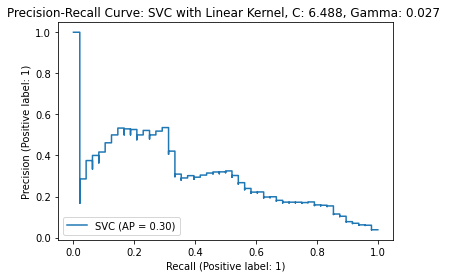

In [95]:
#Precision Recall MSVC2 test

PrecisionRecallDisplay.from_estimator(msvc2, X_testsvct, y_testsvct)
plt.title("Precision-Recall Curve: SVC with Linear Kernel, C: 6.488, Gamma: 0.027 ")
plt.show()

Goodness of Fit and Performance metrics on train set: SVC with Linear kernel, C: 6.488, Gamma: 0.269

In [96]:
#Train SVC2 Predictions

msvc2_pred_train = msvc2.predict(X_trainsvct)

In [97]:
#Accuracy Train MSVC2
msvc2_acc_scoretrain = accuracy_score(y_trainsvct, msvc2_pred_train)
msvc2_acc_scoretrain

0.9708681297339289

In [98]:
#MSVC2 Confusion Matrix TRAIN

conmat_msvc2train = confusion_matrix(y_trainsvct, msvc2_pred_train)

print('Confusion Matrix\n\n', conmat_msvc2train)

print('\nTrue Negatives Not-Bankrupt(TN) = ', conmat_msvc2train[0,0])

print('\nTrue Positive Bankrupt (TP) = ', conmat_msvc2train[1,1])

print('\nFalse Positive False Bankrupt, Actual Not Bankrupt (FP) = ' , conmat_msvc2train[0,1])

print('\nFalse Negative False Not Bankrupt, Actual Bankrupt (FN) = ' , conmat_msvc2train[1,0])

Confusion Matrix

 [[4998    0]
 [ 150    1]]

True Negatives Not-Bankrupt(TN) =  4998

True Positive Bankrupt (TP) =  1

False Positive False Bankrupt, Actual Not Bankrupt (FP) =  0

False Negative False Not Bankrupt, Actual Bankrupt (FN) =  150


In [99]:
#Precision MSVC Train svc2
precision_msvctrain2 = precision_score(y_trainsvct, msvc2_pred_train)
precision_msvctrain2

1.0

In [100]:
#recall Train svc2
recall_msvctrain2 = recall_score(y_trainsvct, msvc2_pred_train)
recall_msvctrain2

0.006622516556291391

In [101]:
#False Positive Rate SVM Linear Kernel Tuned Train

fpr_msvc2train = conmat_msvc2train[0,1]/(conmat_msvc2train[0,1] + conmat_msvc2train[0,0])
print("False Positive Rate:", fpr_msvc2train)

False Positive Rate: 0.0


# Conclusion

The goodness of fit metrics Accuracy and the Precision-Recall curves showed that the Logistic Regression and SVM SVC models produced the highest accuracy on the test set at 96.3%. The Precision-Recall curves showed that the tuned SVM SVC model had the highest balance of precision and recall with precision at under 60% and recall at 30%.

The performance metric F1 score provided comparison between the models, with the Naive Bayes model scoring the highest at 0.25. The other models produced low F1 scores due to predicting 0 or 1 occurrences of bankruptcy. The data was imbalanced, with very low occurrences of bankruptcy in the data set. Future model exploration could include resampling strategies to mitigate data imbalance.